In [4]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import os, re, math, scipy.io, time
import seaborn as sns
from scipy.spatial.distance import directed_hausdorff
from sklearn.cluster import DBSCAN
import traj_dist.distance as tdist
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import fastcluster as fc
import scipy.cluster.hierarchy as sch
import pickle
#%matplotlib inline

In [5]:
# Some visualization stuff, not so important
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)

# Utility Functions
color_lst = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_lst.extend(['firebrick', 'olive', 'indigo', 'khaki', 'teal', 'saddlebrown',
                 'skyblue', 'coral', 'darkorange', 'lime', 'darkorchid', 'dimgray'])
INDEX_RANGE = 1305

In [6]:
def convert_data_into_np_array(number_of_pcs = 2):
    STAGE_DATA_DIR = 'DATA/stage_data'
    data_dict = {}
    traj_list = []
    pair_indexs = range(1, INDEX_RANGE + 4)
    for dir_name in os.listdir(STAGE_DATA_DIR):
        if os.path.isdir(os.path.join(STAGE_DATA_DIR, dir_name)):
            dir_index = int(dir_name.split("_")[0])
            data_fp = os.path.join(STAGE_DATA_DIR, dir_name, "stage_metrics.csv")
            df = pd.read_csv(data_fp, sep=",", header=0).values
            data_dict[dir_index] = {}
            data_dict[dir_index]['pair_name'] = '_'.join(re.sub(r'[\[|\]|\\|\'|\s]', '', df[0, 4]).split(','))
            pcs = df[:, 7: 7 + number_of_pcs].astype(float)
            data_dict[dir_index]['pcs'] = pcs
    pairs_name = ["sox2_t", "gata5_pax8", "lhx1_pax8"]
    for pid, pair in enumerate(pairs_name):
        input_fp = "DATA/target_gene_pairs/%s.csv" % pair
        pcs = pd.read_csv(input_fp, sep=",", header=0).values
        d_id = INDEX_RANGE + pid + 1
        data_dict[d_id] ={}
        data_dict[d_id]['pair_name'] = pair
        data_dict[d_id]['pcs'] = pcs
    for key in pair_indexs:
        traj = data_dict[key]['pcs']
        traj_list.append(traj)
        plt.plot(traj[:, 0], traj[:, 1])
    plt.show()
    return [data_dict, traj_list]

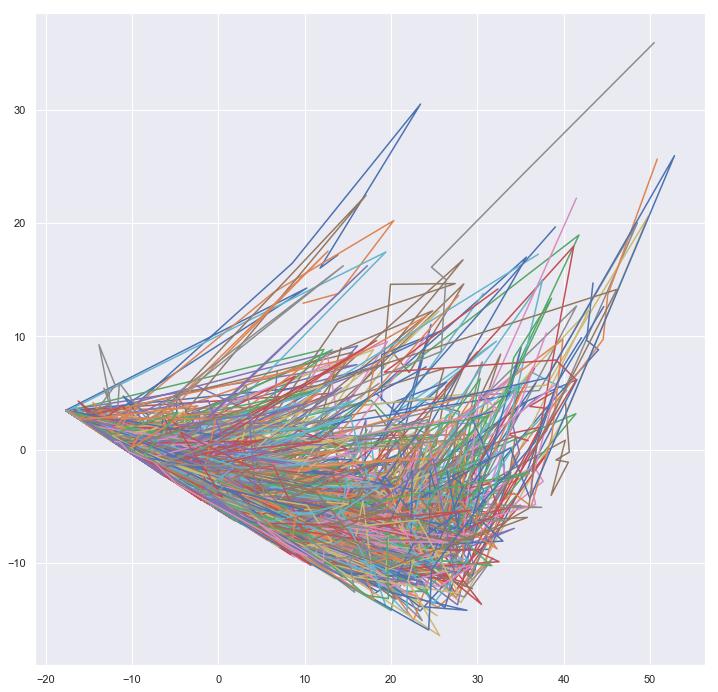

In [7]:
[data_dict, traj_list] = convert_data_into_np_array()

In [8]:
def colorline(ax,
        x, y, z=None, linestyle = 'solid', cmap='gist_rainbow', norm=plt.Normalize(0.0, 1.0),
        linewidth=1, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)
    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha, linestyle=linestyle)

    ax.add_collection(lc)

    return lc

In [9]:
def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

In [10]:
def calc_distance_matrix(distance_fp, traj_list, metric_name):
    ts = time.time()
    p_dist = tdist.pdist(traj_list, metric=metric_name)
    nb_dist = len(p_dist)
    te = time.time()
    print("%d Distances computed in %d seconds" % (nb_dist, te - ts))
    np.save(distance_fp, p_dist)

In [41]:
def plot_cluster(traj_lst, cluster_lst, fig_fp):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    '''
    
    N_COL = 5
    N_ROW = int(math.ceil(float(N_CLUSTER) / N_COL))
    c_arr = np.array([(time_point + 1.)/10. for time_point in range(10)])
    traj_lst = np.array(traj_lst)
    cluster_lst = np.array(cluster_lst)
    fig, axs = plt.subplots(N_ROW, N_COL, figsize=(N_COL * EACH_SUB_FIG_SIZE, N_ROW * EACH_SUB_FIG_SIZE))
    for index, (traj, cluster) in enumerate(zip(traj_lst, cluster_lst)):
        row = cluster // N_COL
        col = cluster % N_COL
        if N_ROW > 1:
            ax = axs[row][col]
        else:
            ax = axs[cluster]
        data_index = index + 1
        if  data_index > INDEX_RANGE:
            # Means it it a noisy trajectory, paint it black
#             ax.plot(traj[:, 0], traj[:, 1], c=c_arr, linestyle='dashed')
            colorline(ax, traj[:, 0], traj[:, 1], c_arr,linestyle='dashed')
            ax.text(0, 0, data_dict[data_index]['pair_name'], color='black')
            ids_in_same_cluster, = np.nonzero(cluster_lst == cluster)
            pair_names = [data_dict[item]['pair_name'] for item in ids_in_same_cluster]
            print(pair_names)
        else:
            
            colorline(ax, traj[:, 0], traj[:, 1], c_arr)
            #ax.plot(traj[:, 0], traj[:, 1], c=color_lst[cluster % len(color_lst)])
        
        ax.set_xlim(-20, 45)
        ax.set_ylim(-20, 40)
    plt.savefig(fig_fp, dpi=200)
    plt.show()

In [42]:
def mkdirs(dir_paths):
    for dir_path in dir_paths:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

### Calculating pair-wised trajactory distance

In [43]:
metric = "sspd"
distance_fp = "DATA/pair_distance_by_%s.npy" % metric
#calc_distance_matrix(distance_fp, traj_list, metric)

['msln-like.2_LOC733735', 'ppl_LOC733735', 'tubb4b_prdm1', 'ugdh.2_ccno', 'pax6_fam57a', 'tbc1d2b_myl4']
['LOC733735_LOC100490289-like', 'ag1_LOC100490918-like', 'atp1b2_LOC101734069-like', 'cnfn.1_LOC100490918-like', 'dact1_LOC100490918-like', 'ppl_pcdh7', 'rnd1_LOC100490918-like', 'slc16a3_LOC100490918-like', 'ddit3_admp', 'kpna2_dbn1', 'neurog1_id3', 'foxa4_a2ml1', 'hoxc10_ferd3l', 'LOC595077_LOC100145611', 'Xetrov90028339m_Xetrov90017310m', 'ag1_LOC100494819-like', 'dll1_akap9', 'flnb_LOC100145611', 'grasp_LOC100145611', 'hand2_arpc1a', 'hes6.1_chga', 'klf11_LOC101734297-like', 'klf5_LOC101734297-like', 'klf5_Xetrov90017310m', 'msln-like.2_gch1', 'nans_dbn1', 'napa_LOC101734297-like', 'nrp1_hipk1', 'pcnp_crisp1', 'prph_ag1', 'prph_mgat1', 'prph_nans', 'rab3a_LOC100216126', 'rab3a_LOC101734297-like', 'rab3a_Xetrov90017310m', 'slc16a3_LOC594901', 'slc16a3_LOC733482', 'tmem45b_basp1', 'ubp1_slc9a3r1', 'ubp1_sox2', 'ubp1_tox3', 'ubtd1_crisp1', 'ugdh.2_LOC100491886', 'ugdh.2_LOC10173225

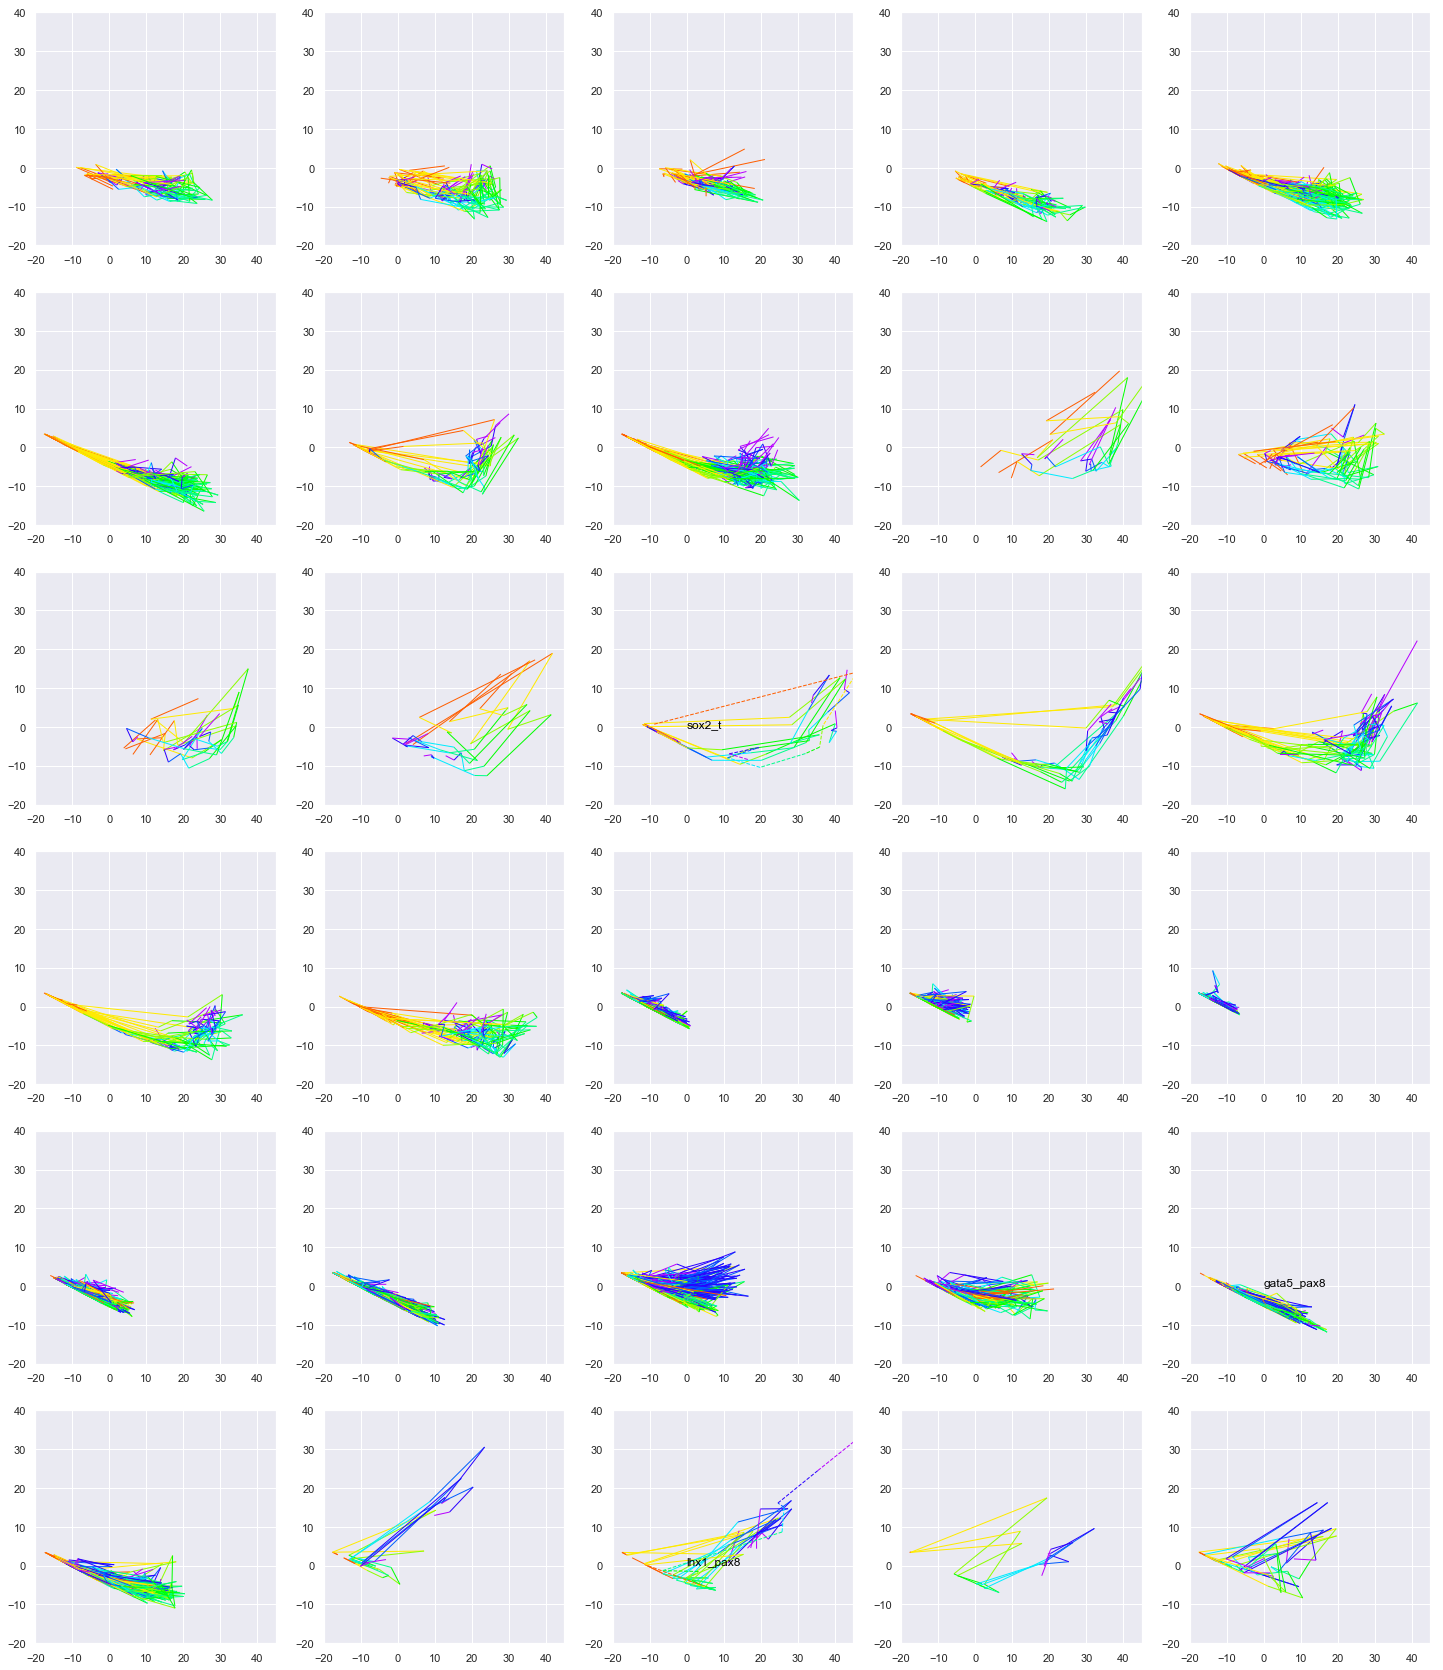

In [44]:
N_CLUSTER =30
EACH_SUB_FIG_SIZE = 5
fig_dir = 'figure_outputs/Traj_clusters'
mkdirs([fig_dir])
distance_fp = "DATA/pair_distance_by_%s.npy" % metric
fig_fp = os.path.join(fig_dir, "cluster_by_%s.png" % metric)
p_dist = np.load(distance_fp)
Z = fc.linkage(p_dist, method="ward")
labels =sch.fcluster(Z, N_CLUSTER , criterion="maxclust")-1
plot_cluster(traj_list, labels, fig_fp)